In [1]:
from IPython.utils import io
from itertools import cycle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io.arff import loadarff 

#Funções de avaliação dos modelos
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score,
)
from sklearn.model_selection import(
    train_test_split, 
    KFold,
    GridSearchCV,
)

from sklearn.preprocessing import label_binarize

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adamax
from keras.wrappers.scikit_learn import KerasClassifier

#utils
from utils.num import Num

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC

Limitando o uso de VRAM

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

2022-09-01 13:34:18.021232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 13:34:18.050000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 13:34:18.050172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Definição de funções auxiliares

### Métricas

In [4]:
def compute_metrics(y_true, y_pred, y_score=None):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    if y_score is not None:
        # Compute ROC curve and ROC area for each class
        n_classes = len(np.unique(y_true))
        y_bin = label_binarize(y_true, classes=np.arange(n_classes))

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        thresholds = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        return accuracy, f1, conf_matrix, (fpr, tpr, roc_auc)
    
    return accuracy, f1, conf_matrix

def save_metrics(model_name, acc, f1, cm, roc=None):
    with open(f'{model_name}_metrics.npy', 'wb') as f:
        np.save(f, acc, allow_pickle=True)
        np.save(f, f1, allow_pickle=True)
        np.save(f, cm, allow_pickle=True)
        if roc is not None:
            np.save(f, roc, allow_pickle=True)

def load_metrics(model_name):
    with open(f'metrics/{model_name}_metrics.npy', 'rb') as f:
        acc = np.load(f, allow_pickle=True)
        f1 = np.load(f, allow_pickle=True)
        cm = np.load(f, allow_pickle=True)
        roc = np.load(f, allow_pickle=True)
    return acc, f1, cm, roc

def plot_roc_curve(fpr, tpr, roc_auc):
    n_classes = 10
    lw=2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()
    
def plot_metrics(model_name:str, acc:list,
                 f1:list, cm:list, roc:list) -> None:
    print(f"Resumo das métricas do modelo {model_name}\n")
    print(f"Accurácia média (desvio): {np.mean(acc):.3f} ({np.std(acc):.3f})")
    print(f"F1-Score média (desvio): {np.mean(f1):.3f} ({np.std(f1):.3f})")

    # Confusion Matrix
    cm_mean = np.mean(cm, axis=0)
    ax = sns.heatmap(cm_mean, linewidths=0.5, annot=True, fmt='g')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title('Matriz de Confusão Média')
    ax.set_xlabel('Classes preditas')
    ax.set_ylabel('Classes verdadeiras')
    plt.show()
    

### Para K-Fold CV e GridSearch

In [5]:
def kfold_run(kf, model, X, y):
      accuracies_list = list()
      f1_list = list()
      conf_matrix_list = list()
      roc_list = list()
      grid_results = list()
      for fold, (train, test) in enumerate(kf.split(X, y)):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
            y_train = y_train.values.ravel()

            with io.capture_output() as captured:
                  model.fit(X_train, y_train)
                  y_pred = model.predict(X_test)
                  y_score = model.predict_proba(X_test)

            acc, f1, conf_matrix, roc = compute_metrics(y_test, y_pred, y_score)

            print(f"Fold {fold}\t Accuracy: {acc:.3f}")

            if hasattr(model, 'best_params_'):
                  print(F"Model best params: {model.best_params_}")
                  grid_results.append(model.cv_results_)

            accuracies_list.append(acc)
            f1_list.append(f1)
            conf_matrix_list.append(conf_matrix)
            roc_list.append(roc)

      return accuracies_list, f1_list, conf_matrix_list, roc_list, grid_results


def grid_Search(kf, model, params, X, y, n_jobs=None):
      grid = GridSearchCV(estimator=model, param_grid=params,
                          scoring='accuracy', n_jobs=n_jobs, 
                          cv=5, refit=True)

      return kfold_run(kf, grid, X, y)

### Implementando MLP pelo Keras

In [6]:
def MLP(input_shape, n_classes, n_neurons,
        activation='relu', loss='categorical_crossentropy',
        optimizer=Adam, lr=0.001, metrics=['accuracy']):
    
    model = Sequential()
    
    first_layer_neurons = n_neurons.pop(0)
    model.add(Dense(first_layer_neurons, 
                input_shape=input_shape,
                activation=activation))
    
    for n_neuron in n_neurons:
        model.add(Dense(n_neuron, activation=activation))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss=loss, optimizer=optimizer(lr), metrics=metrics)

    return model

### Visualização de instâncias do DS

In [7]:
# plot multiple numbers

def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='gray_r')
        ax.axis('off')
    
    fig.suptitle('Representação de números aleatórios do dataset')

# DataSet

### Carregando o DataSet

In [8]:
# loading data
raw_data = loadarff('mnist_784.arff')
mnist = pd.DataFrame(raw_data[0])

Devido à limitações de hardware, tomaremos uma amostra estratificada de tamanho n = 2000

In [9]:
#
df = mnist.groupby('class', group_keys=False).apply(
    lambda x: x.sample(500, random_state=1, ignore_index=True)
    ).sample(frac=1, ignore_index=True, random_state=1)

df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'9'
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'7'
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'6'
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'1'
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'7'


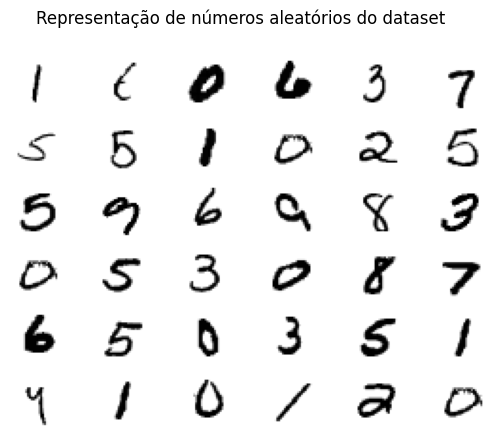

In [10]:
# Visualizando algumas instância do dataset
nums = df['class'].unique()

imgs = list()
for i in np.random.randint(100, size=36):
    rnd_choice = np.random.choice(nums)
    img = pd.array(df[df['class'] == rnd_choice].iloc[i][:-1],
                 dtype=int).reshape((28,28))
    imgs.append(img)

plot_images(imgs)


#### Separando os dados de treino e teste

In [11]:
# treino e teste
X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int') # target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)

kf = KFold(n_splits=10, shuffle=True)

# Experimentos

### Decision Tree

Fold 0	 Accuracy: 0.724
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 5}
Fold 1	 Accuracy: 0.722
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 10}
Fold 2	 Accuracy: 0.731
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 5}
Fold 3	 Accuracy: 0.758
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 5}
Fold 4	 Accuracy: 0.753
Model best params: {'criterion': 'gini', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 5}
Fold 5	 Accuracy: 0.769
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 5}
Fold 6	 Accuracy: 0.753
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 5}
Fold 7	 Accuracy: 0.756
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'm

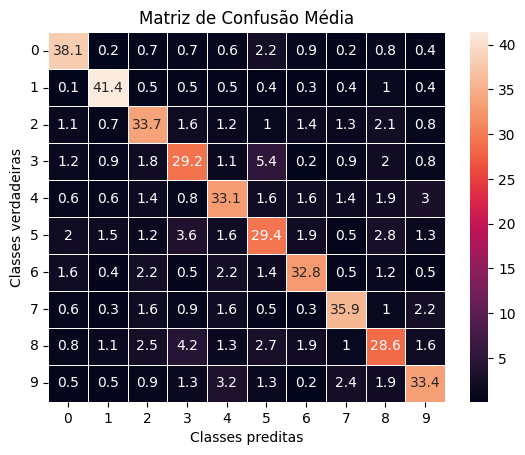

In [58]:

DT = DecisionTreeClassifier()
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth':[5, 50, 100],
    'min_samples_split': [5, 10, 30],
    'max_features':[10, 30, 100, 'sqrt'],
}
dt_acc, dt_f1, dt_cm, dt_roc, dt_grid_results = grid_Search(kf, DT, dt_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(DT).__name__, dt_acc, dt_f1, dt_cm, dt_roc)


### Naive Bayes

#### Gaussian NB

Fold 0	 Accuracy: 0.800
Model best params: {'var_smoothing': 0.1}
Fold 1	 Accuracy: 0.831
Model best params: {'var_smoothing': 0.1}
Fold 2	 Accuracy: 0.820
Model best params: {'var_smoothing': 0.1}
Fold 3	 Accuracy: 0.780
Model best params: {'var_smoothing': 0.1}
Fold 4	 Accuracy: 0.818
Model best params: {'var_smoothing': 0.1}
Fold 5	 Accuracy: 0.804
Model best params: {'var_smoothing': 0.1}
Fold 6	 Accuracy: 0.831
Model best params: {'var_smoothing': 0.1}
Fold 7	 Accuracy: 0.793
Model best params: {'var_smoothing': 0.1}
Fold 8	 Accuracy: 0.787
Model best params: {'var_smoothing': 0.1}
Fold 9	 Accuracy: 0.831
Model best params: {'var_smoothing': 0.1}

-----------------------------------------------------

Resumo das métricas do modelo GaussianNB

Accurácia média (desvio): 0.810 (0.018)
F1-Score média (desvio): 0.810 (0.018)


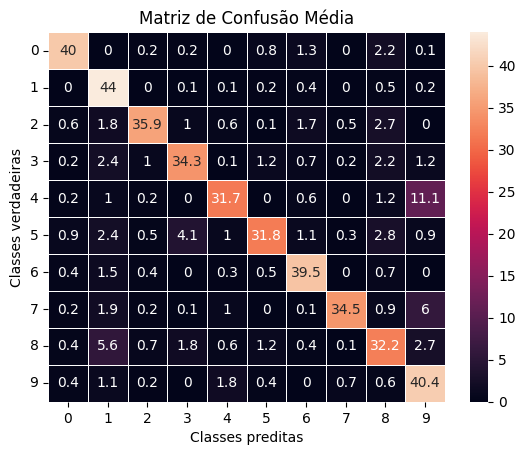

In [51]:
gnb = GaussianNB()
gnb_params = {
    'var_smoothing': np.logspace(0,-9, num=10)
}

gnb_acc, gnb_f1, gnb_cm, gnb_roc, gnb_grid_results = grid_Search(kf, gnb, gnb_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(gnb).__name__, gnb_acc, gnb_f1, gnb_cm, gnb_roc)


#### Multinomial NB

Fold 0	 Accuracy: 0.853
Model best params: {'alpha': 0.01}
Fold 1	 Accuracy: 0.847
Model best params: {'alpha': 0.1}
Fold 2	 Accuracy: 0.833
Model best params: {'alpha': 0.01}
Fold 3	 Accuracy: 0.824
Model best params: {'alpha': 1e-06}
Fold 4	 Accuracy: 0.824
Model best params: {'alpha': 1e-08}
Fold 5	 Accuracy: 0.851
Model best params: {'alpha': 1e-09}
Fold 6	 Accuracy: 0.793
Model best params: {'alpha': 1.0}
Fold 7	 Accuracy: 0.849
Model best params: {'alpha': 0.0001}
Fold 8	 Accuracy: 0.847
Model best params: {'alpha': 0.01}
Fold 9	 Accuracy: 0.824
Model best params: {'alpha': 1e-05}

-----------------------------------------------------

Resumo das métricas do modelo MultinomialNB

Accurácia média (desvio): 0.835 (0.018)
F1-Score média (desvio): 0.836 (0.018)


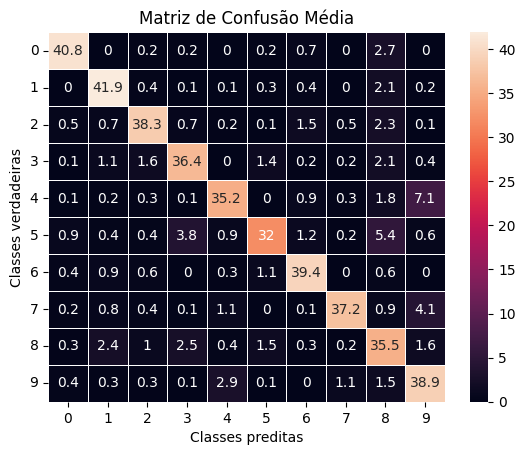

In [81]:
mnnb = MultinomialNB()
mnnb_params = {
    'alpha': np.logspace(0,-9, num=10)
}

mnnb_acc, mnnb_f1, mnnb_cm, mnnb_roc, mnnb_grid_results = grid_Search(kf, mnnb, mnnb_params,
                                                   X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(mnnb).__name__, mnnb_acc, mnnb_f1, mnnb_cm, mnnb_roc)

### MLP

In [ ]:
mlp = KerasClassifier(build_fn=MLP, n_classes=10, input_shape=(28*28,), verbose=0)

mlp_params = {
    'epochs': [20, 30, 50],
    'batch_size':[128, 256],
    'n_neurons':[[250]*2, [500]*2, [250]*3, [500]*3],
    'optimizer': [Adam, Adamax, SGD],
    'lr': [0.001, 0.002, 0.003],
}


mlp_acc, mlp_f1, mlp_cm, mlp_roc, mlp_grid_results = grid_Search(kf, mlp, mlp_params, X_train, y_train, n_jobs=2)

print("\n-----------------------------------------------------\n")
plot_metrics('MLP', mlp_acc, mlp_f1, mlp_cm, mlp_roc)


### KNN

Fold 0	 Accuracy: 0.920
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 1	 Accuracy: 0.924
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 2	 Accuracy: 0.922
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 3	 Accuracy: 0.913
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 4	 Accuracy: 0.929
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 5	 Accuracy: 0.929
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 6	 Accuracy: 0.938
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 7	 Accuracy: 0.916
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 8	 Accuracy: 0.931
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 9	 Accuracy: 0.927
Model best params: {'metric': 'euclidean', 'n_neighbors': 5}

-----------------------------------------------------

Resumo das métricas do modelo KNeighborsClassifier

Accurácia média (desvio): 0.925 (0.007)
F1

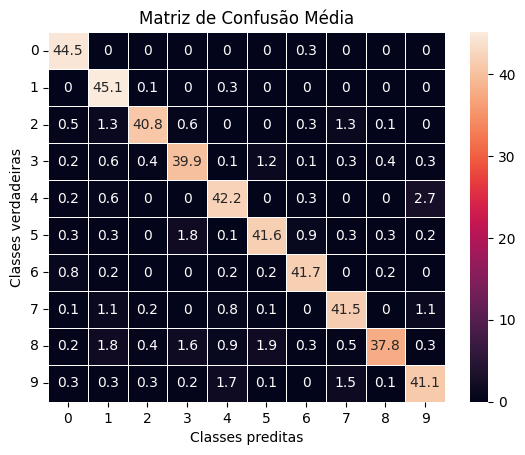

In [55]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7],
             'metric': ['euclidean', 'manhattan']}

knn_acc, knn_f1, knn_cm, knn_roc, knn_grid_results = grid_Search(kf, knn, knn_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(knn).__name__, knn_acc, knn_f1, knn_cm, knn_roc)

### SVC

Fold 0	 Accuracy: 0.931
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 1	 Accuracy: 0.956
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 2	 Accuracy: 0.969
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 3	 Accuracy: 0.960
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 4	 Accuracy: 0.920
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Fold 5	 Accuracy: 0.949
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Fold 6	 Accuracy: 0.936
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Fold 7	 Accuracy: 0.938
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 8	 Accuracy: 0.936
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 9	 Accuracy: 0.936
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}

-----------------------------------------------------

Resumo das métricas do modelo SVC

Accurácia média (desvio): 0.

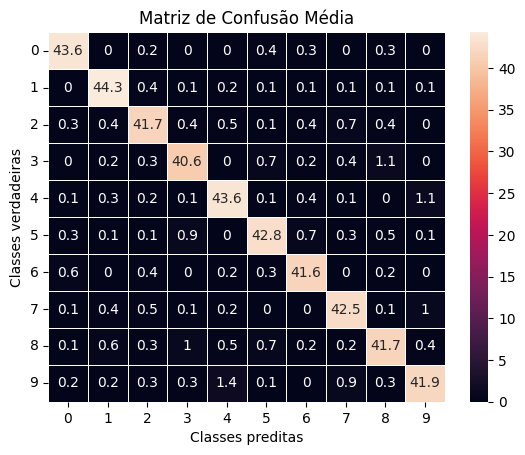

In [60]:
svc = SVC(probability=True)

svc_params = [
    {'C': np.logspace(4,-1, num=6),
     'kernel':['linear']},
    
    {'C': np.logspace(4,-1, num=6),
     'kernel': ['poly'],
     'degree': [2, 3]},
]

svc_acc, svc_f1, svc_cm, svc_roc, svc_grid_results = grid_Search(kf, svc, svc_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
plot_metrics(type(svc).__name__, svc_acc, svc_f1, svc_cm, svc_roc)


### Salvando as métricas

In [89]:
# save_metrics(type(DT).__name__, dt_acc, dt_f1, dt_cm, dt_roc)
# save_metrics(type(gnb).__name__, gnb_acc, gnb_f1, gnb_cm, gnb_roc)
# save_metrics(type(mnnb).__name__, mnnb_acc, mnnb_f1, mnnb_cm, mnnb_roc)
# save_metrics('MLP', mlp_acc, mlp_f1, mlp_cm, mlp_roc)
# save_metrics(type(knn).__name__, knn_acc, knn_f1, knn_cm, knn_roc)
# save_metrics(type(svc).__name__, svc_acc, svc_f1, svc_cm, svc_roc)